en este código hacemos:
1.- generamos un conjunto de datos con dependencias condicionales
2.- aprendemos la estructura de los datos (generamos un DAG) usando causal learn

necesitamos instalar:  
pip install git+https://github.com/py-why/causal-learn.git


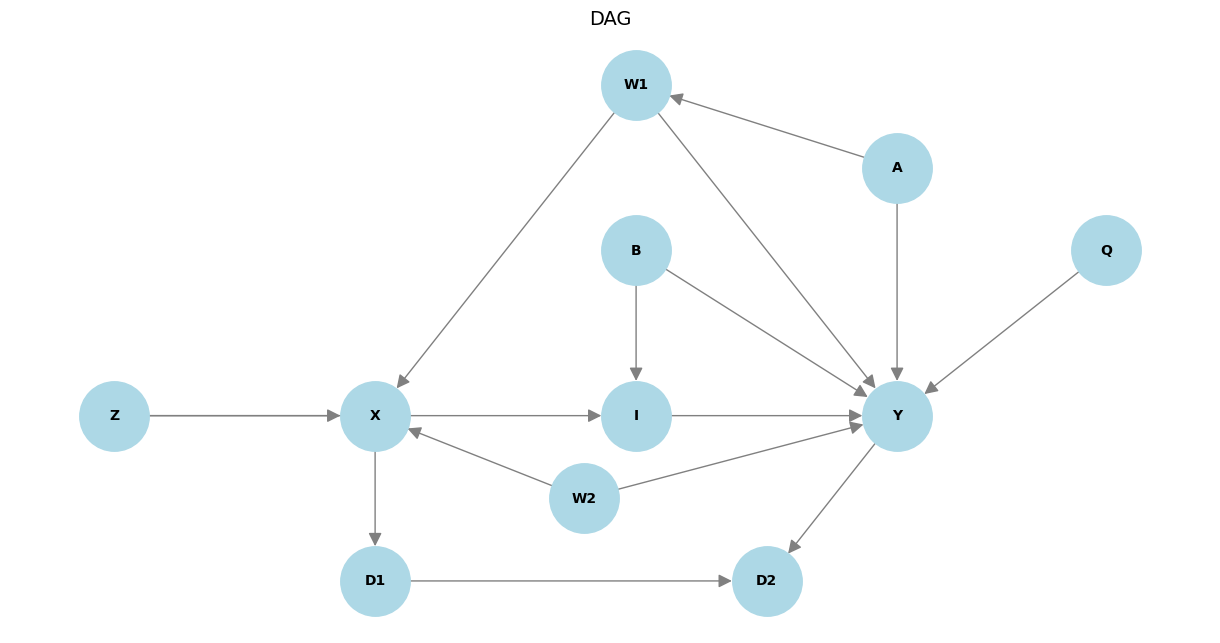

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

# 1. Crear el DAG según las relaciones especificadas
edges = [
    ("Z", "X"),
    ("Z", "I"),
    ("I", "Y"),
    ("X", "D1"),
    ("D1", "D2"),
    ("Y", "D2"),
    ("B", "I"),
    ("B", "Y"),
    ("Q", "Y"),
    ("A", "Y"),
    ("A", "W1"),
    ("W1", "X"),
    ("W1", "Y"),
    ("W2", "X"),
    ("W2", "Y")
]

G = nx.DiGraph()
G.add_edges_from(edges)

# 2. Definir posiciones manuales para evitar cruces y alinear nodos clave
pos = {
    "Z":  (0, 0),
    "X":  (1, 0),
    "I":  (2, 0),
    "Y":  (3, 0),
    "D1": (1, -1),
    "D2": (2.5, -1),

    "B":  (2, 1),
    "Q":  (3.8, 1),
    "A":  (3, 1.5),
    "W1": (2, 2),
    "W2": (1.8, -0.5)
}

# Ajustar automáticamente nodos que no tienen posición definida (por si acaso)
for node in G.nodes():
    if node not in pos:
        pos[node] = (0, 0)

# 3. Dibujar el DAG con formato personalizado
plt.figure(figsize=(12, 6))
nx.draw(
    G, pos,
    with_labels=True,
    node_color='lightblue',
    node_size=2500,
    font_size=10,
    arrows=True,
    arrowsize=20,
    edge_color='gray',
    font_weight='bold'
)
plt.title("DAG", fontsize=14)
plt.axis("off")
plt.show()


In [3]:
import numpy as np
import pandas as pd
# 3. Generar datos sintéticos coherentes con el DAG
np.random.seed(42)
n = 25
data = pd.DataFrame()

# Variables exógenas primero (sin padres)
data["Z1"] = np.random.binomial(1, 0.5, n)
data["B"] = np.random.normal(0, 1, n)
data["Q"] = np.random.normal(0, 1, n)
data["A"] = np.random.normal(0, 1, n)
data["W2"] = np.random.binomial(1, 0.5, n)

# Variables con dependencias
data["Z"] = 1.5 * data["Z1"] + np.random.normal(0, 1, n)
data["W1"] = 0.7 * data["A"] + np.random.normal(0, 1, n)
data["X"] = 0.8 * data["W1"] + 0.6 * data["W2"] + np.random.normal(0, 1, n)
data["I"] = 0.6 * data["Z"] + 0.8 * data["B"] + np.random.normal(0, 1, n)
data["D1"] = 0.7 * data["X"] + np.random.normal(0, 1, n)
data["Y"] = (
    1.2 * data["I"]
    + 0.5 * data["B"]
    + 0.3 * data["Q"]
    + 0.6 * data["A"]
    + 0.9 * data["W1"]
    + 0.7 * data["W2"]
    + np.random.normal(0, 1, n)
)
data["D2_continuous"] = 0.8 * data["D1"] + 0.6 * data["Y"] + np.random.normal(0, 1, n)
data["D2"] = (data["D2_continuous"] > data["D2_continuous"].mean()).astype(int)
data.drop(columns=["D2_continuous"], inplace=True)

# Verifica estructura final
print("Variables en el dataset:", data.columns.tolist())
print(data.head())


Variables en el dataset: ['Z1', 'B', 'Q', 'A', 'W2', 'Z', 'W1', 'X', 'I', 'D1', 'Y', 'D2']
   Z1         B         Q         A  W2         Z        W1         X  \
0   0 -0.629475 -0.538142  3.372296   1 -0.291953  2.588067  3.083235   
1   1  0.597720 -1.346678 -0.920391   0  1.465288  0.662869  1.352356   
2   1  2.559488 -0.880591 -0.398638   1  0.331322 -1.886530  0.987569   
3   1  0.394233 -1.130552 -0.060864   0  2.642823  0.142029 -0.131765   
4   0  0.122219  0.134429 -1.418750   0  0.751933 -0.733243 -1.340330   

          I        D1         Y  D2  
0 -1.125267  2.917234  2.433618   1  
1  2.213748  0.173824  2.480966   1  
2  2.460477  0.454480  3.236067   0  
3  0.655341 -0.577599  1.601423   0  
4  0.722116 -0.856357 -1.743487   0  


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import fisherz

# 1. Usa los datos generados
df = data[["W1", "W2", "B", "X", "I", "Y", "D1", "D2", "Z1", "Q", "A", "Z"]]
data_np = df.to_numpy()
labels = df.columns.to_list()

# 2. Ejecutar algoritmo PC
cg = pc(data_np, alpha=0.01, indep_test_func=fisherz, labels=labels)



  0%|          | 0/12 [00:00<?, ?it/s]

In [5]:
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import fisherz

# Ejecutar el algoritmo PC
cg = pc(data_np, alpha=0.01, indep_test_func=fisherz, labels=labels)



  0%|          | 0/12 [00:00<?, ?it/s]

c:\Users\econo\.conda\envs\causal_ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


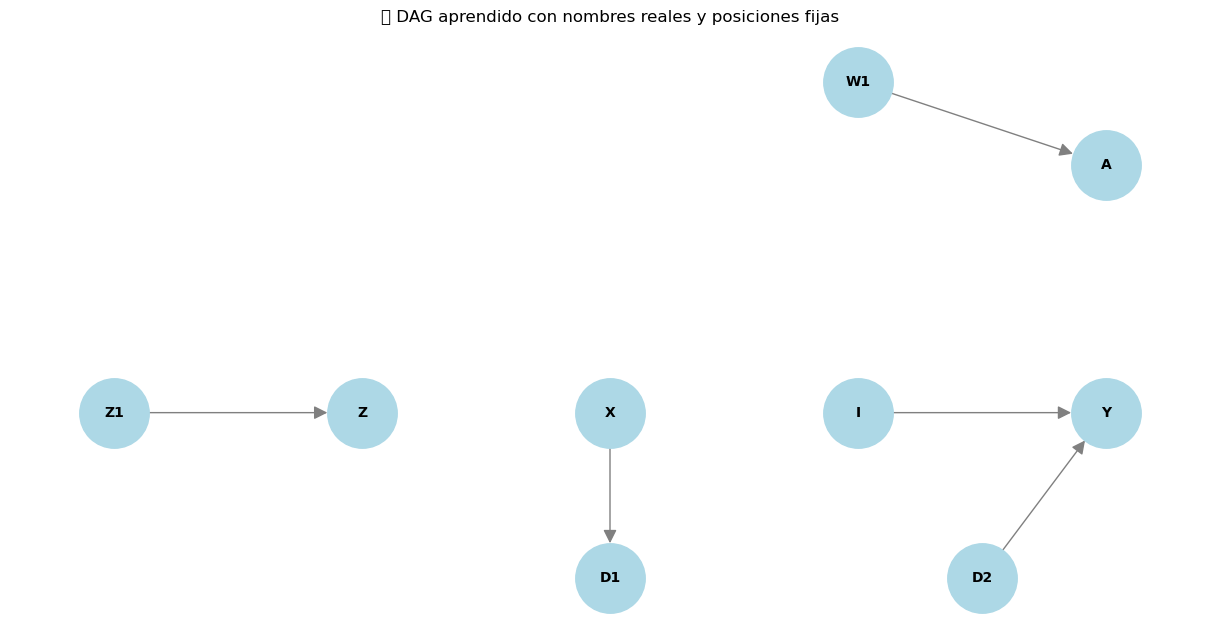

In [6]:
import networkx as nx
import matplotlib.pyplot as plt

# 1. Lista de nombres reales, ordenada como en data_np
labels = ["W1", "W2", "B", "X", "I", "Y", "D1", "D2", "Z1", "Q", "A", "Z"]

# 2. Extraer y convertir aristas desde cg
converted_edges = []

for edge in cg.G.get_graph_edges():
    node1 = edge.node1.get_name()  # e.g., "X1"
    node2 = edge.node2.get_name()

    # Convertir "Xn" → índice → nombre real
    idx1 = int(node1[1:]) - 1
    idx2 = int(node2[1:]) - 1

    name1 = labels[idx1]
    name2 = labels[idx2]

    converted_edges.append((name1, name2))

# 3. Crear grafo
G = nx.DiGraph()
G.add_edges_from(converted_edges)

# 4. Posiciones personalizadas
pos = {
    "Z":  (0, 0),
    "X":  (1, 0),
    "I":  (2, 0),
    "Y":  (3, 0),
    "D1": (1, -1),
    "D2": (2.5, -1),
    "B":  (2, 1),
    "Q":  (3.8, 1),
    "A":  (3, 1.5),
    "W1": (2, 2),
    "W2": (1.8, -0.5),
    "Z1": (-1, 0)
}

# 5. Agregar posición por defecto a nodos no incluidos
for node in G.nodes():
    if node not in pos:
        pos[node] = (0, 0)

# 6. Dibujar
plt.figure(figsize=(12, 6))
nx.draw(
    G, pos,
    with_labels=True,
    node_color='lightblue',
    node_size=2500,
    font_size=10,
    arrows=True,
    arrowsize=20,
    edge_color='gray',
    font_weight='bold'
)
plt.title("📈 DAG aprendido con nombres reales y posiciones fijas")
plt.axis("off")
plt.show()
